# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

### Take A Look At Data
The first step of exploring the data is just to take a look at it. 

In [4]:
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


The frequent appearance of missing values immediately comes to attention. Depending on the extent of missingness and characteristics of data that have missing values, deletion or imputation needs to be applied properly.

After a quick look up of some features' meaning in the 'metadata' file `DIAS Information Levels - Attributes 2017`, it becomes clear that NOT all features are listed in the metadata file, making it difficult for us to interpret and process those data. 

Almost all data in the dataset have been numerically encoded. Some features are ordinal, such as `WOHNLAGE` (quality of the residential area, ranging from 'very good' to 'very poor' and even 'rural') and can be left as they are when proceeding to modeling, while others are categorical, such as `ANREDE_KZ` (gender), which require constructing dummy variables for them.

### Determine Which Features Are Documented In Metadata

#### Create Metadata
`attributes.csv` is created, documenting the list of features from `DIAS Information Levels - Attributes 2017` and datatype (categorical, ordinal and numeric) of each feature after referring to `DIAS Attributes - Values 2017`. The file is then read into a pd.DataFrame. 

In [5]:
# get the array of attributes in the metadata file
metadata = pd.read_csv('attributes.csv', header = None)
metadata.columns = ['feature', 'type', 'description', 'unknown', 'info_lev']
metadata.index = metadata['feature']

attr_ls = metadata.index

# no. of features in metadata file
len(attr_ls)

318

In [6]:
# find list of common features between dataset and metadata file
intersect_ls = np.intersect1d(attr_ls, azdias.columns)

# no. of common features
len(intersect_ls)

272

In [7]:
# no. of features in  the dataset with no documented metadata
no_metadata = list(set(azdias.columns) ^ set(intersect_ls))
len(no_metadata)

94

The metadata contains 318 features, of which 266 match exactly with those in the German demography (azdias) dataset. That means, there are 366-272=94 features in the dataset not documented in Metadata.

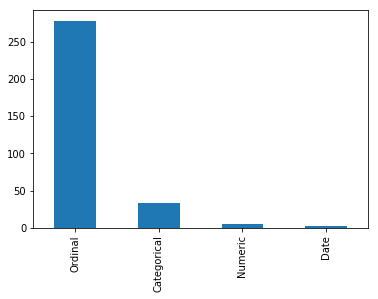

In [10]:
metadata['type'].value_counts().plot(kind='bar')

Most features in the metadata are Ordinal, less than 1/7 of them are Categorical, and only a couple are Numeric.

In our dataset, two predominant dtypes are 'int64' and 'float64'. We need to know what other datatypes are there and whether dtype can indicate type of feature.

In [11]:
import random

for i in range(10):
    random_feature = random.choice(intersect_ls)
    print(random_feature, '\n', azdias[random_feature].dtype, metadata.loc[random_feature, 'type'])

KBA13_BJ_2008 
 float64 Ordinal
D19_VERSI_ONLINE_DATUM 
 int64 Ordinal
KBA05_HERST4 
 float64 Ordinal
KBA05_SEG4 
 float64 Ordinal
KBA13_KRSHERST_AUDI_VW 
 float64 Ordinal
KBA13_VORB_1 
 float64 Ordinal
HH_EINKOMMEN_SCORE 
 float64 Ordinal
KBA13_KMH_110 
 float64 Ordinal
KBA13_SEG_OBEREMITTELKLASSE 
 float64 Ordinal
KBA13_VORB_3 
 float64 Ordinal


Repeating the `random.choice()` process several time, and it becomes clear that we cannot determine type of feature by looking at dtype. A feature with dtype = 'int64' can be Ordinal or Categorical, and the same can be said about 'float64' variables.

In [12]:
for i in azdias.columns:
    if azdias[i].dtype not in ['int64',  'float64']:
        print(azdias[i].head(5))

0    NaN
1     8A
2     4C
3     2A
4     6B
Name: CAMEO_DEU_2015, dtype: object
0    NaN
1      8
2      4
3      2
4      6
Name: CAMEO_DEUG_2015, dtype: object
0    NaN
1     51
2     24
3     12
4     43
Name: CAMEO_INTL_2015, dtype: object
0              NaN
1              NaN
2    D19_UNBEKANNT
3    D19_UNBEKANNT
4       D19_SCHUHE
Name: D19_LETZTER_KAUF_BRANCHE, dtype: object
0                    NaN
1    1992-02-10 00:00:00
2    1992-02-12 00:00:00
3    1997-04-21 00:00:00
4    1992-02-12 00:00:00
Name: EINGEFUEGT_AM, dtype: object
0    NaN
1      W
2      W
3      W
4      W
Name: OST_WEST_KZ, dtype: object


There are 6 variables with dtype = 'object'. Most of them are Categorical. Some are not listed in metadata file and requires cautious encoding. 

#### Making sense of undocumented features

In [8]:
print(no_metadata)

['D19_GARTEN', 'KBA13_KMH_210', 'D19_BANKEN_ANZ_24', 'AKT_DAT_KL', 'D19_BUCH_CD', 'FIRMENDICHTE', 'KBA13_ANTG1', 'CJT_TYP_6', 'ALTER_KIND4', 'EINGEZOGENAM_HH_JAHR', 'UMFELD_JUNG', 'D19_BANKEN_DIREKT', 'CJT_TYP_1', 'CJT_KATALOGNUTZER', 'MOBI_RASTER', 'D19_DROGERIEARTIKEL', 'D19_RATGEBER', 'KBA13_HHZ', 'D19_KOSMETIK', 'ANZ_KINDER', 'VK_DHT4A', 'STRUKTURTYP', 'KK_KUNDENTYP', 'CJT_TYP_4', 'D19_BANKEN_GROSS', 'ALTER_KIND1', 'D19_TELKO_MOBILE', 'D19_BIO_OEKO', 'ALTERSKATEGORIE_FEIN', 'VK_DISTANZ', 'D19_BANKEN_ANZ_12', 'ALTER_KIND3', 'CJT_TYP_3', 'KBA13_CCM_3001', 'LNR', 'DSL_FLAG', 'D19_HANDWERK', 'D19_WEIN_FEINKOST', 'D19_NAHRUNGSERGAENZUNG', 'RT_KEIN_ANREIZ', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LEBENSMITTEL', 'D19_SOZIALES', 'D19_TIERARTIKEL', 'D19_BANKEN_LOKAL', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_SCHUHE', 'D19_BILDUNG', 'KBA13_CCM_1401_2500', 'D19_KINDERARTIKEL', 'CAMEO_INTL_2015', 'D19_FREIZEIT', 'KBA13_ANTG2', 'SOHO_KZ', 'D19_BEKLEIDUNG_GEH', 'ANZ_STATISTISCHE_HAUSHALTE', 'VK_ZG11', 'D19_RE

#### Investigating D19_ family
It seems that 'D19_' features comprise a large portion of the undocumented feature group (there are a total 94 of them). It would be helpful to investigate into this feature family. 

no. of missing values:  0


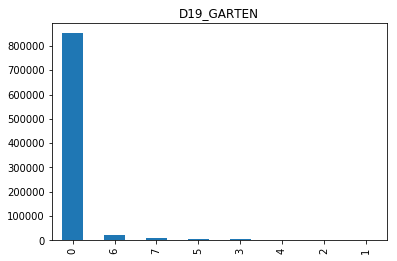

no. of missing values:  0


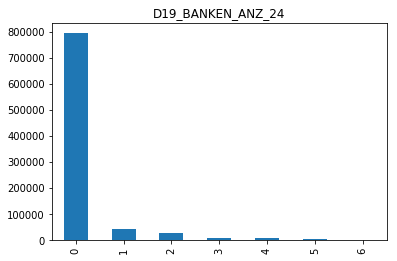

no. of missing values:  0


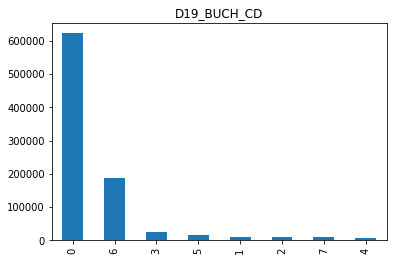

no. of missing values:  0


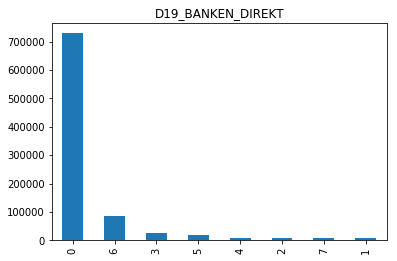

no. of missing values:  0


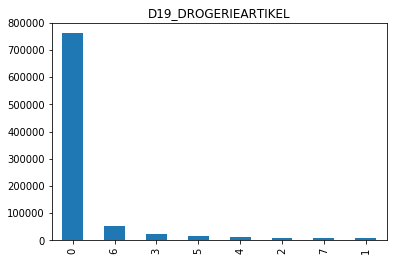

no. of missing values:  0


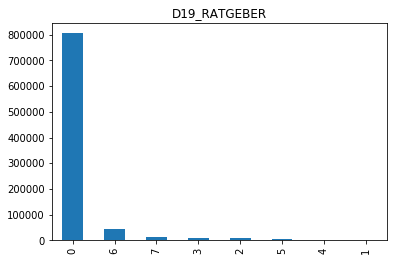

no. of missing values:  0


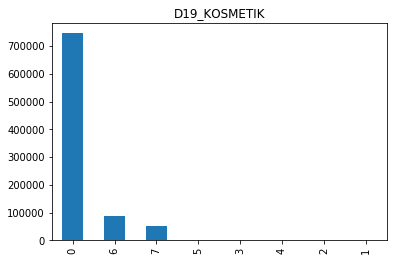

no. of missing values:  0


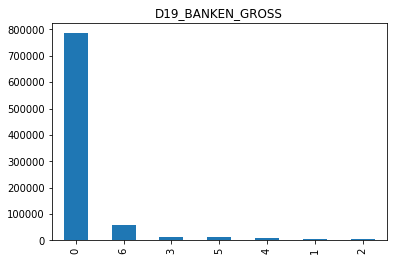

no. of missing values:  0


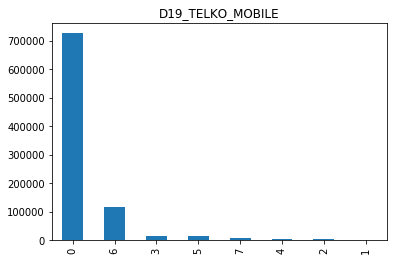

no. of missing values:  0


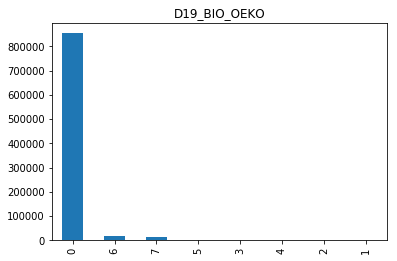

no. of missing values:  0


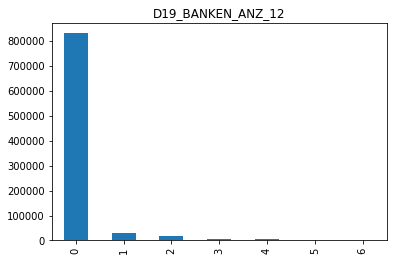

no. of missing values:  0


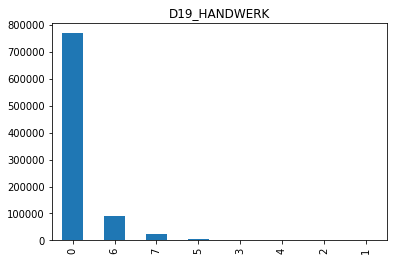

no. of missing values:  0


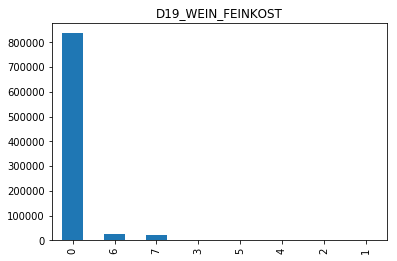

no. of missing values:  0


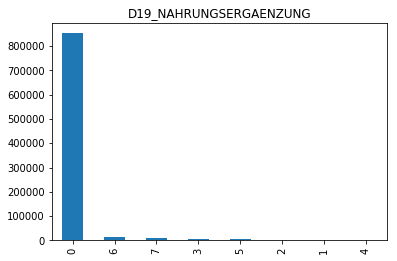

no. of missing values:  257113


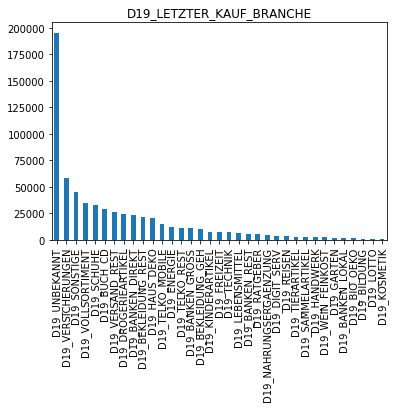

no. of missing values:  0


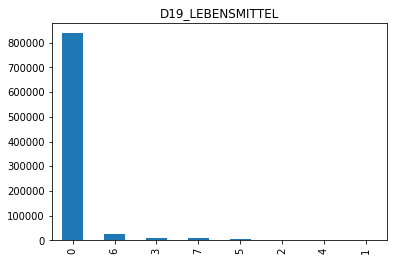

no. of missing values:  257113


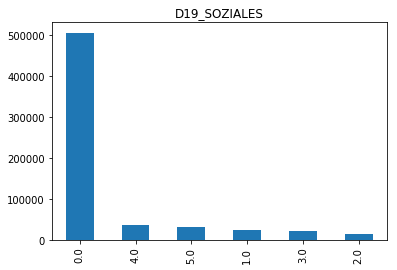

no. of missing values:  0


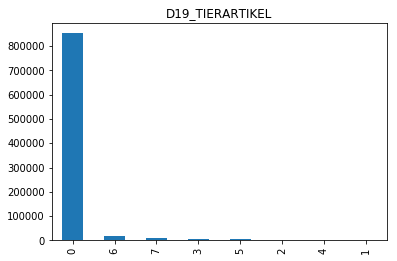

no. of missing values:  0


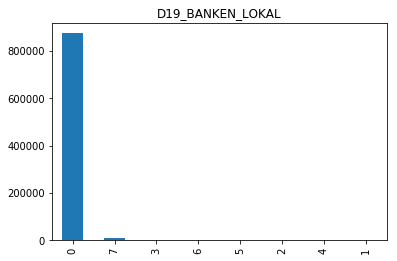

no. of missing values:  257113


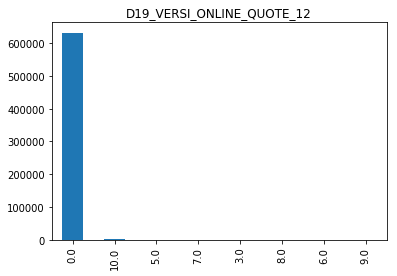

no. of missing values:  0


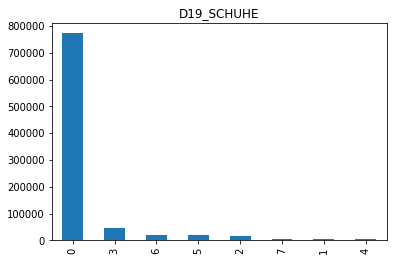

no. of missing values:  0


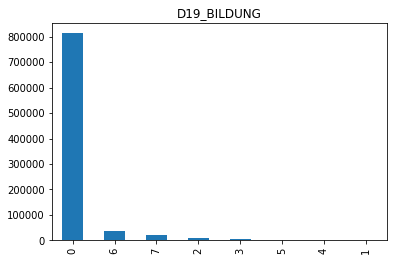

no. of missing values:  0


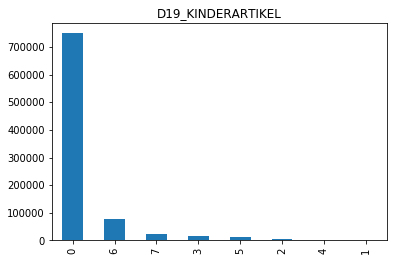

no. of missing values:  0


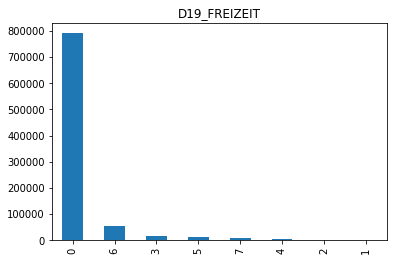

no. of missing values:  0


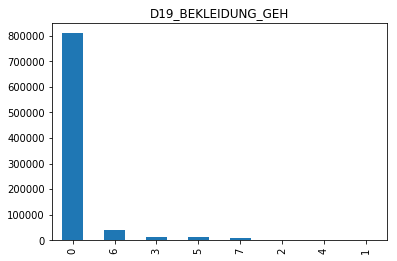

no. of missing values:  0


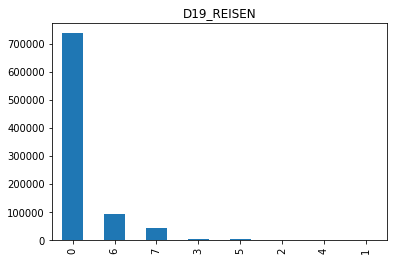

no. of missing values:  0


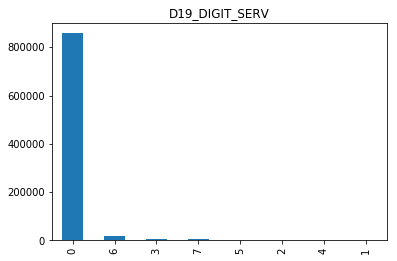

no. of missing values:  0


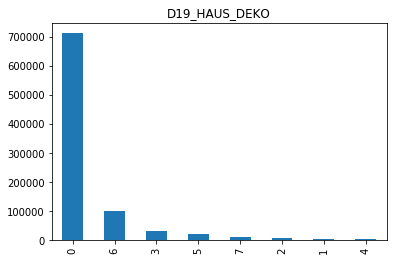

no. of missing values:  0


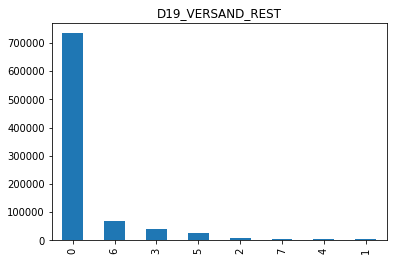

no. of missing values:  0


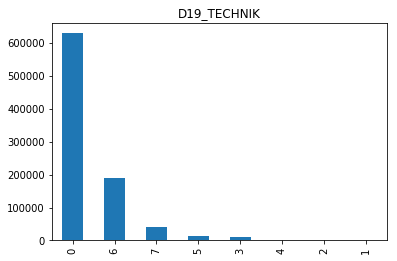

no. of missing values:  0


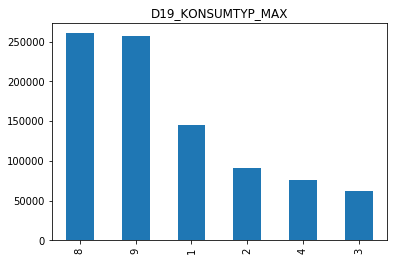

no. of missing values:  0


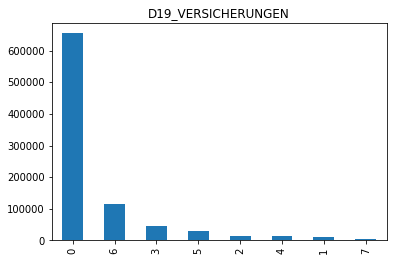

no. of missing values:  257113


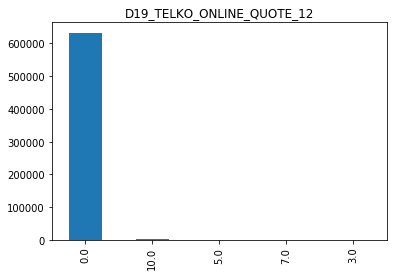

no. of missing values:  0


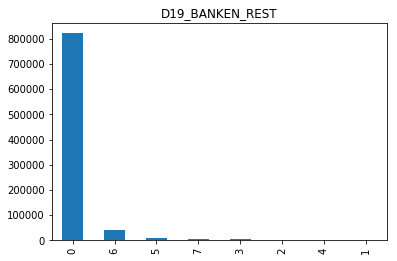

no. of missing values:  0


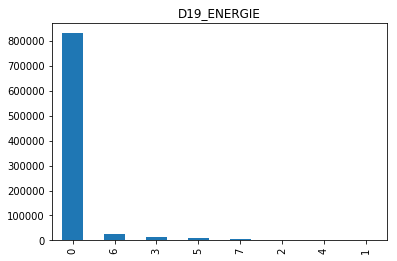

no. of missing values:  0


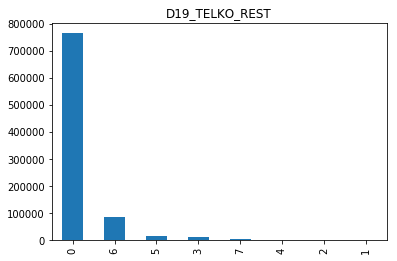

no. of missing values:  0


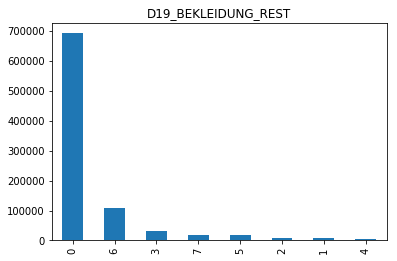

no. of missing values:  0


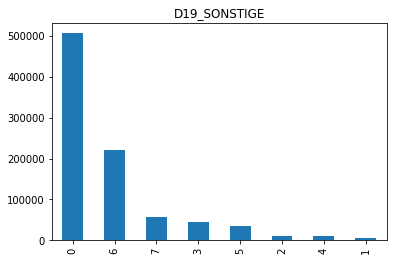

no. of missing values:  0


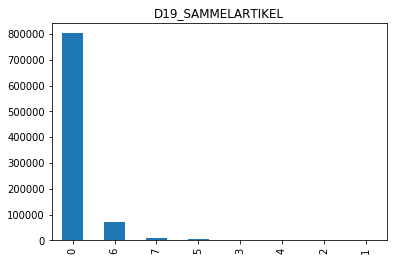

no. of missing values:  257113


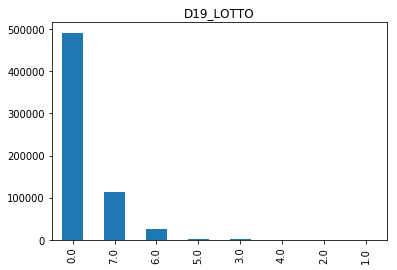

no. of missing values:  0


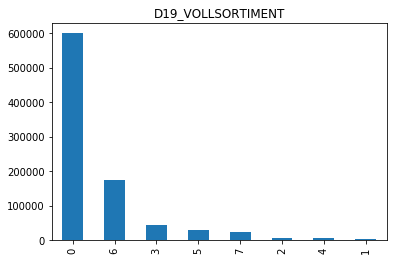

In [24]:
D19_features = []
D19_na_list = []

for i in no_metadata:
    if i.startswith('D19_'):
        D19_features.append(i)
        na_cnt = azdias[i].isna().sum()
        print('no. of missing values: ', na_cnt)
        azdias[i].value_counts().plot(kind='bar')
        plt.title(i)
        plt.show()
        if na_cnt > 0:
            D19_na_list.append([i, na_cnt])

In [25]:
print(len(D19_features))
print(D19_na_list)

41
[['D19_LETZTER_KAUF_BRANCHE', 257113], ['D19_SOZIALES', 257113], ['D19_VERSI_ONLINE_QUOTE_12', 257113], ['D19_TELKO_ONLINE_QUOTE_12', 257113], ['D19_LOTTO', 257113]]


In [33]:
LETZTER = azdias['D19_LETZTER_KAUF_BRANCHE'].unique()
len(LETZTER)

36

In [115]:
LETZTER

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
       'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
       'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
       'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
       'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object)

In [35]:
set(LETZTER) ^ set(D19_features)

{'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_KONSUMTYP_MAX',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_UNBEKANNT',
 'D19_VERSI_ONLINE_QUOTE_12',
 nan}

'D19_' family has 41 members. Among the 890,000 + records, 257,113 are missing values for this 'D19_' family features. 

Based on observation, my theory about D19_ family:

'D19_LETZTER_KAUF_BRANCHE', 'D19_KONSUMTYP_MAX', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12' are features at general level.

Each individual is categorized in 'D19_LETZTER_KAUF_BRANCHE', and if not categorized as 'D19_UNBEKANNT' (probably meaning unknown), will be further categorized in the 35 sub-features.

In [111]:
'''
To test the theory, randomly pick a record, find its category according to feature 'D19_LETZTER_KAUF_BRANCHE'.
and then find the value for the feature named by that category.
It should be a non-zero number.
Then check the value of the same record for feature named by another category under 'D19_LETZTER_KAUF_BRANCHE'.
It should be a zero number.
'''

import random

i = 21327

r = azdias.loc[i, 'D19_LETZTER_KAUF_BRANCHE']
print(r, azdias.loc[i, r])

j = random.choice(LETZTER)
print(j, azdias.loc[i, j])

D19_DROGERIEARTIKEL 5
D19_TECHNIK 6


After repeating the cell above several times, it turns out only the first half of the theory is proven correct. One thing is for sure, that zero values for those features that have 80 percent of values being zeros do not mean unknown or unavailable, and we should not treat them as missing values. 

### Investigating KBA13_ family

no. of missing values:  105800


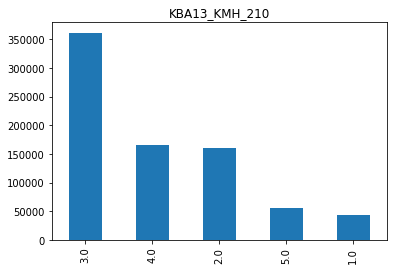

no. of missing values:  105800


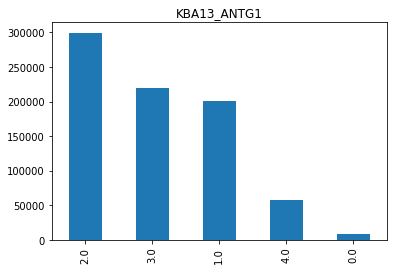

no. of missing values:  105800


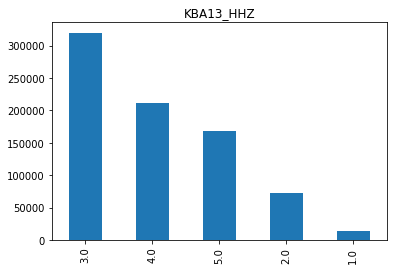

no. of missing values:  105800


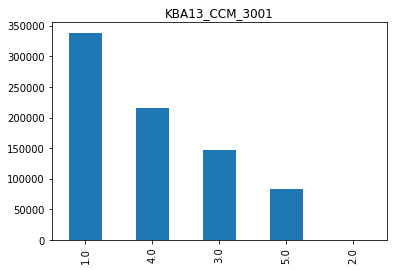

no. of missing values:  105800


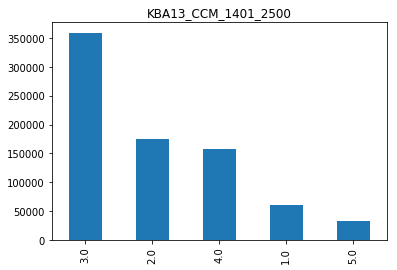

no. of missing values:  105800


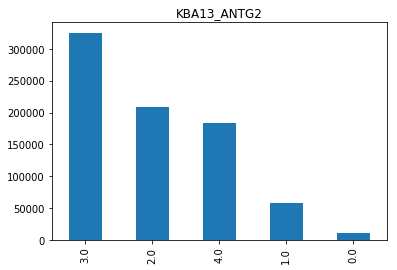

no. of missing values:  105800


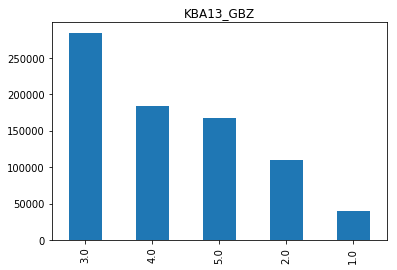

no. of missing values:  105800


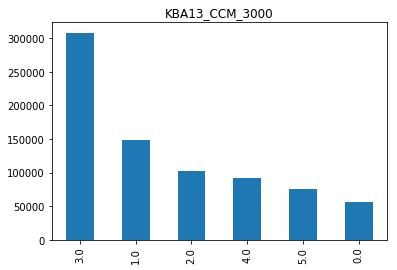

no. of missing values:  105800


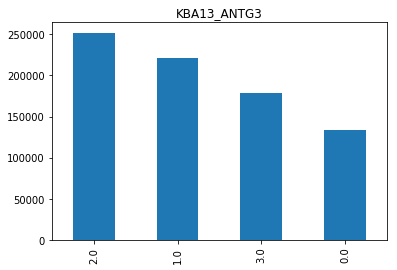

no. of missing values:  105800


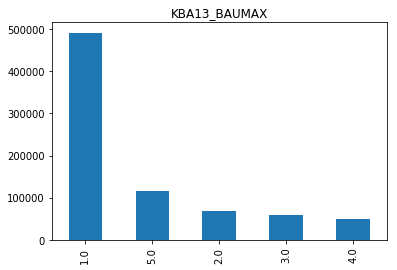

no. of missing values:  105800


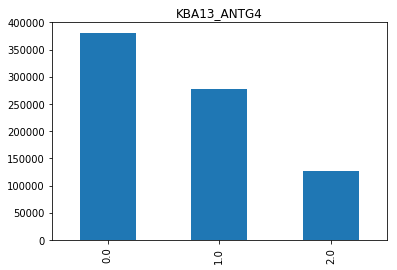

In [113]:
KBA13_cnt = 0
KBA13_features = []
KBA13_na_list = []

for i in no_metadata:
    if i.startswith('KBA13_'):
        KBA13_features.append(i)
        na_cnt = azdias[i].isna().sum()
        print('no. of missing values: ', na_cnt)
        azdias[i].value_counts().plot(kind='bar')
        plt.title(i)
        plt.show()
        if na_cnt > 0:
            KBA13_na_list.append([i, na_cnt])

In [114]:
print(len(KBA13_features))
print(KBA13_na_list)

11
[['KBA13_KMH_210', 105800], ['KBA13_ANTG1', 105800], ['KBA13_HHZ', 105800], ['KBA13_CCM_3001', 105800], ['KBA13_CCM_1401_2500', 105800], ['KBA13_ANTG2', 105800], ['KBA13_GBZ', 105800], ['KBA13_CCM_3000', 105800], ['KBA13_ANTG3', 105800], ['KBA13_BAUMAX', 105800], ['KBA13_ANTG4', 105800]]


All 11 features in the KBA13_ family have 105,800 missing values, probabily by the same 105,800 individuals. Judging by the value distribution, and the fact that all KBA13_ features documented in metadata file are all ordinal data, there's high chance that these variables in question are also, and should be treated as, ordinal data.

#### Investigating CJT_ family

no. of missing values:  4854


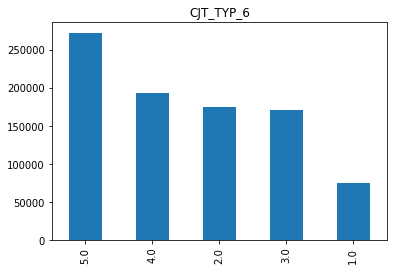

no. of missing values:  4854


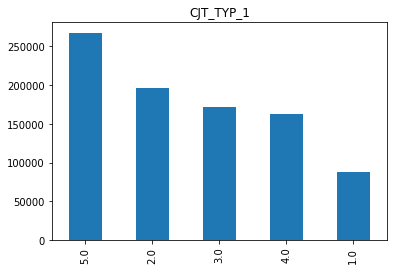

no. of missing values:  4854


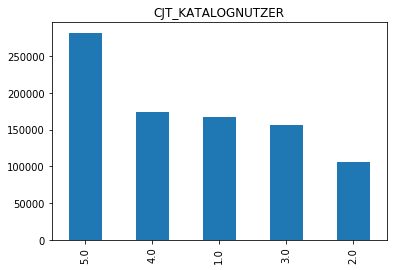

no. of missing values:  4854


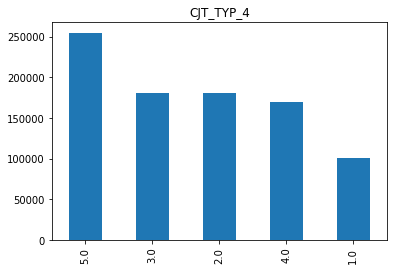

no. of missing values:  4854


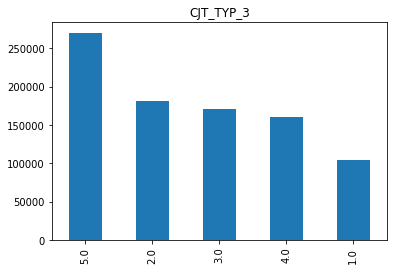

no. of missing values:  4854


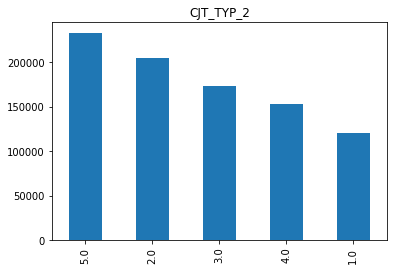

no. of missing values:  4854


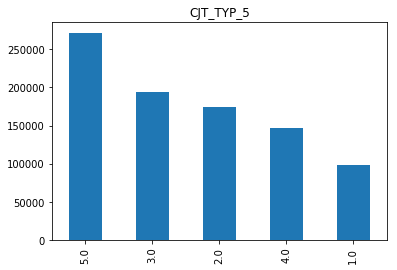

In [116]:
CJT_cnt = 0
CJT_features = []
CJT_na_list = []

for i in no_metadata:
    if i.startswith('CJT_'):
        CJT_features.append(i)
        na_cnt = azdias[i].isna().sum()
        print('no. of missing values: ', na_cnt)
        azdias[i].value_counts().plot(kind='bar')
        plt.title(i)
        plt.show()
        if na_cnt > 0:
            CJT_na_list.append([i, na_cnt])

In [117]:
print(len(CJT_features))
print(CJT_na_list)

7
[['CJT_TYP_6', 4854], ['CJT_TYP_1', 4854], ['CJT_KATALOGNUTZER', 4854], ['CJT_TYP_4', 4854], ['CJT_TYP_3', 4854], ['CJT_TYP_2', 4854], ['CJT_TYP_5', 4854]]


##### Handling Missing Values

In [137]:
azdias_na = azdias.isna().mean()

(array([113.,   0.,   1.,  15., 147.,  74.,   0.,   0.,   0.,   0.,   0.,
         10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   2.]),
 array([0.        , 0.0249662 , 0.0499324 , 0.07489859, 0.09986479,
        0.12483099, 0.14979719, 0.17476339, 0.19972958, 0.22469578,
        0.24966198, 0.27462818, 0.29959438, 0.32456057, 0.34952677,
        0.37449297, 0.39945917, 0.42442537, 0.44939157, 0.47435776,
        0.49932396, 0.52429016, 0.54925636, 0.57422256, 0.59918875,
        0.62415495, 0.64912115, 0.67408735, 0.69905355, 0.72401974,
        0.74898594, 0.77395214, 0.79891834, 0.82388454, 0.84885073,
        0.87381693, 0.89878313, 0.92374933, 0.94871553, 0.97368172,
        0.99864792]),
 <a list of 40 Patch objects>)

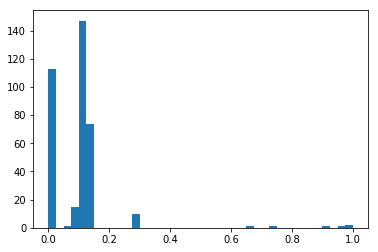

In [140]:
plt.hist(azdias_na, bins=40)

In [291]:
azdias_na = pd.DataFrame(np.zeros(azdias.shape), columns=azdias.columns)
azdias_na.shape

(891221, 366)

In [293]:
for feature in intersect_ls:
    unknown = metadata.loc[feature, 'unknown']
    if isinstance(unknown, str):
        unknown = unknown.split(',')
        unknown = [int(i) for i in unknown if unknown[0] not in ['None', 'N/A']]
    print(feature, '\n', 'unknown values:', unknown)
    print('no. of na before conversion:', azdias[feature].isna().sum())
    azdias_na[feature] = azdias[feature].replace(to_replace=unknown, value=np.nan)
    print('no. of na after conversion:', azdias_na[feature].isna().sum(), '\n')

AGER_TYP 
 unknown values: [-1, 0]
no. of na before conversion: 0
no. of na after conversion: 685843 

ALTERSKATEGORIE_GROB 
 unknown values: [-1, 0]
no. of na before conversion: 0
no. of na after conversion: 0 

ALTER_HH 
 unknown values: [0]
no. of na before conversion: 73499
no. of na after conversion: 310267 

ANREDE_KZ 
 unknown values: [-1, 0]
no. of na before conversion: 0
no. of na after conversion: 0 

ANZ_HAUSHALTE_AKTIV 
 unknown values: []
no. of na before conversion: 93148
no. of na after conversion: 93148 

ANZ_HH_TITEL 
 unknown values: []
no. of na before conversion: 97008
no. of na after conversion: 97008 

ANZ_PERSONEN 
 unknown values: []
no. of na before conversion: 73499
no. of na after conversion: 73499 

ANZ_TITEL 
 unknown values: []
no. of na before conversion: 73499
no. of na after conversion: 73499 

ARBEIT 
 unknown values: nan
no. of na before conversion: 97216
no. of na after conversion: 97216 

BALLRAUM 
 unknown values: [-1]
no. of na before conversion: 

no. of na before conversion: 133324
no. of na after conversion: 148110 

KBA05_HERST5 
 unknown values: [-1, 9]
no. of na before conversion: 133324
no. of na after conversion: 148110 

KBA05_HERSTTEMP 
 unknown values: [-1, 9]
no. of na before conversion: 93148
no. of na after conversion: 110037 

KBA05_KRSAQUOT 
 unknown values: [-1, 9]
no. of na before conversion: 133324
no. of na after conversion: 148110 

KBA05_KRSHERST1 
 unknown values: [-1, 9]
no. of na before conversion: 133324
no. of na after conversion: 148110 

KBA05_KRSHERST2 
 unknown values: [-1, 9]
no. of na before conversion: 133324
no. of na after conversion: 148110 

KBA05_KRSHERST3 
 unknown values: [-1, 9]
no. of na before conversion: 133324
no. of na after conversion: 148110 

KBA05_KRSKLEIN 
 unknown values: [-1, 9]
no. of na before conversion: 133324
no. of na after conversion: 148110 

KBA05_KRSOBER 
 unknown values: [-1, 9]
no. of na before conversion: 133324
no. of na after conversion: 148110 

KBA05_KRSVAN 
 

no. of na before conversion: 105800
no. of na after conversion: 105800 

KBA13_HALTER_40 
 unknown values: [-1]
no. of na before conversion: 105800
no. of na after conversion: 105800 

KBA13_HALTER_45 
 unknown values: [-1]
no. of na before conversion: 105800
no. of na after conversion: 105800 

KBA13_HALTER_50 
 unknown values: [-1]
no. of na before conversion: 105800
no. of na after conversion: 105800 

KBA13_HALTER_55 
 unknown values: [-1]
no. of na before conversion: 105800
no. of na after conversion: 105800 

KBA13_HALTER_60 
 unknown values: [-1]
no. of na before conversion: 105800
no. of na after conversion: 105800 

KBA13_HALTER_65 
 unknown values: [-1]
no. of na before conversion: 105800
no. of na after conversion: 105800 

KBA13_HALTER_66 
 unknown values: [-1]
no. of na before conversion: 105800
no. of na after conversion: 105800 

KBA13_HERST_ASIEN 
 unknown values: [-1]
no. of na before conversion: 105800
no. of na after conversion: 105800 

KBA13_HERST_AUDI_VW 
 unknown

no. of na before conversion: 121196
no. of na after conversion: 158064 

KONSUMNAEHE 
 unknown values: []
no. of na before conversion: 73969
no. of na after conversion: 73969 

LP_FAMILIE_FEIN 
 unknown values: []
no. of na before conversion: 4854
no. of na after conversion: 4854 

LP_FAMILIE_GROB 
 unknown values: []
no. of na before conversion: 4854
no. of na after conversion: 4854 

LP_LEBENSPHASE_FEIN 
 unknown values: []
no. of na before conversion: 4854
no. of na after conversion: 4854 

LP_LEBENSPHASE_GROB 
 unknown values: []
no. of na before conversion: 4854
no. of na after conversion: 4854 

LP_STATUS_FEIN 
 unknown values: []
no. of na before conversion: 4854
no. of na after conversion: 4854 

LP_STATUS_GROB 
 unknown values: []
no. of na before conversion: 4854
no. of na after conversion: 4854 

MIN_GEBAEUDEJAHR 
 unknown values: []
no. of na before conversion: 93148
no. of na after conversion: 93148 

MOBI_REGIO 
 unknown values: []
no. of na before conversion: 133324
no. 

In [294]:
azdias_na.shape

(891221, 366)

In [295]:
missing_rate = [azdias_na[i].isna().mean() for i in azdias_na.columns]

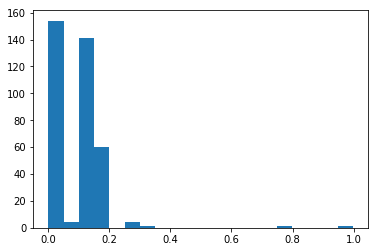

In [297]:
_ = plt.hist(missing_rate, bins=20)
plt.show()

In [303]:
dem_ord = azdias_na[i in intersect_ls if metadata.loc[i,'type']=='Ordinal']
dem_ord.shape

SyntaxError: invalid syntax (<ipython-input-303-ed764c6d1bda>, line 1)

In [133]:
pop = azdias.drop(labels=a.index, axis=1)
pop.shape

(891221, 360)

### Check Missing Values Across Records

(array([5.73319e+05, 1.69441e+05, 4.02300e+03, 3.79400e+03, 1.41000e+02,
        6.08000e+02, 5.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.23640e+04, 8.89700e+03, 2.11800e+03, 5.64000e+02, 9.10000e+01,
        5.00000e+01, 6.00000e+00, 0.00000e+00, 4.08000e+02, 3.34600e+03,
        9.89000e+02, 1.78400e+03, 2.60000e+01, 8.00000e+00, 5.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 7.70000e+01, 1.75800e+03,
        3.44500e+03, 5.95000e+02, 1.68000e+02, 2.90000e+01, 1.47210e+04,
        1.30000e+02, 4.71200e+03, 4.60000e+01, 2.79570e+04, 4.55960e+04]),
 array([0.        , 0.01756944, 0.03513889, 0.05270833, 0.07027778,
        0.08784722, 0.10541667, 0.12298611, 0.14055556, 0.158125  ,
        0.17569444, 0.19326389, 0.21083333, 0.22840278, 0.24597222,
        0.26354167, 0.28111111, 0.29868056, 0.31625   , 0.33381944,
        0.35138889, 0.36895833, 0.38652778, 0.40409722, 0.42166667,
        0.43923611, 0.45680556, 0.474375  , 0.49194444, 0.50951389,
      

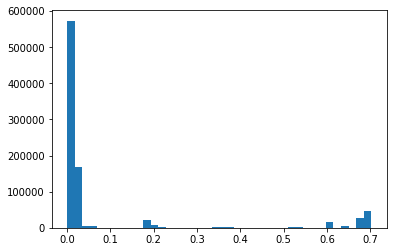

In [155]:
pop_na = pop.isna().mean(axis=1)
plt.hist(pop_na,bins=40)

In [157]:
index = np.array([i < 0.3 for i in pop_na])
np.mean(index)

0.881286459811876

In [161]:
# Divide population into two subgroup: 
pop_0 = pop.iloc[[i < 0.3 for i in pop_na], :]   #_0: records with low missing rate
pop_1 = pop.iloc[[i >= 0.3 for i in pop_na], :]   #_1: records with high missing rate
pop_1.shape

(105800, 360)

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')